# Getting some quick picks for 2023-04-08

http://ufcstats.com/event-details/3dc3022232b79c7a

https://www.bestfightodds.com/events/ufc-287-2760

Unfortunately I forgot to run the full script prior to this, so it's a bit jank

In [1]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db import base_db_interface

raw_df = base_db_interface.read("bfo_espn_ufc_features")
for dt_col in ["Date", "DOB", "DOB_opp"]:
    raw_df[dt_col] = pd.to_datetime(raw_df[dt_col])
raw_df[["FighterOpen", "OpponentOpen"]] = raw_df[["FighterOpen", "OpponentOpen"]]\
    .astype(float)

raw_df = raw_df.drop_duplicates(subset=["FighterID_espn", "OpponentID_espn", "fight_id"])
raw_df["FighterID_espn"] = raw_df["FighterID_espn"].fillna("unknown")
raw_df["OpponentID_espn"] = raw_df["OpponentID_espn"].fillna("unknown")
print(raw_df.shape)
raw_df.head() # show the first 5 rows

(133102, 248)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,prev_weight,FighterID_espn_opp,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,2354059,0,0,0,NaN,0.0,185.0,185.0,NaN
1,1991-09-26_2354059_2558095,1991-09-26,W,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2558095,2354059,NaN,...,NaN,2558095,0,0,0,NaN,0.0,NaN,NaN,NaN
2,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,2501396,0,0,0,NaN,0.0,185.0,185.0,NaN
3,1992-01-01_2354119_2501396,1992-01-01,L,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2354119,2501396,NaN,...,NaN,2354119,0,0,0,NaN,0.0,170.0,170.0,NaN
4,1993-08-29_2354132_3107994,1993-08-29,W,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,3107994,2354132,NaN,...,NaN,3107994,0,0,0,NaN,0.0,NaN,NaN,NaN


# Awful, Ugly, Stinky, No-Good Hack

Necessary in order to get data for the upcoming fights. The join is very difficult

In [168]:
from wrangle.clean_espn_data import EspnDataCleaner

# Get odds for upcoming fight
bfo_df = base_db_interface.read("clean_fighter_odds_data")
bfo_df["Date"] = pd.to_datetime(bfo_df["Date"])
bfo_to_espn_map = base_db_interface.read("bfo_to_espn_map")
upcoming_bfo_df = bfo_df.query("EventHref == \
                               '/events/ufc-fight-night-holloway-vs-allen-2796'")
upcoming_bfo_df = upcoming_bfo_df.rename(
    columns={"FighterID": "FighterID_bfo", "OpponentID": "OpponentID_bfo"}
)
print(upcoming_bfo_df.shape)
upcoming_bfo_df = upcoming_bfo_df.merge(
    bfo_to_espn_map[["FighterID_bfo", "FighterID_espn"]].drop_duplicates(),
    on=["FighterID_bfo"],
    how="left"
).merge(
    bfo_to_espn_map[["OpponentID_bfo", "OpponentID_espn"]].drop_duplicates(),
    on=["OpponentID_bfo"],
    how="left"
)

print(upcoming_bfo_df.shape)
# Get bios for fighters in upcoming fight
espn_dc = EspnDataCleaner()
espn_dc._parse_bios()
espn_dc.clean_bio_df
bio_df = espn_dc.clean_bio_df.rename(columns={
    "FighterID":"FighterID_espn", "Name": "BioName",
})
upcoming_bfo_df = upcoming_bfo_df.merge(
    bio_df,
    left_on="FighterID_espn",
    right_on="FighterID_espn",
    how="left",
    suffixes=("_dropme", "")
).merge(
    bio_df,
    left_on="OpponentID_espn",
    right_on="FighterID_espn",
    how="left",
    suffixes=("", "_opp")
)
print(upcoming_bfo_df.shape)

upcoming_bfo_df.head()

(30, 17)
(30, 19)
(30, 40)


,Event,EventHref,Date,FighterID_bfo,OpponentID_bfo,FighterName,OpponentName,FighterOpen,OpponentOpen,FighterCloseLeft,...,BioName_opp,FighterID_espn_opp,Country_opp,WT Class_opp,Team_opp,Nickname_opp,ReachInches_opp,WeightPounds_opp,HeightInches_opp,DOB_opp
0,UFC Fight Night: Holloway vs. Allen,/events/ufc-fight-night-holloway-vs-allen-2796,2023-04-15,Aaron-Phillips-4905,Gaston-Bolanos-6991,aaron phillips,gaston bolanos,+140,-160,+150,...,gaston bolaños,4393818,USA,Bantamweight,Combat Sports Academy,The Dreamkiller,69.0,135.0,67.0,1992-09-14
1,UFC Fight Night: Holloway vs. Allen,/events/ufc-fight-night-holloway-vs-allen-2796,2023-04-15,Arnold-Allen-4218,Max-Holloway-3090,arnold allen,max holloway,+125,-145,+145,...,max holloway,2614933,USA,Featherweight,Gracie Technics,Blessed,69.0,146.0,71.0,1991-12-04
2,UFC Fight Night: Holloway vs. Allen,/events/ufc-fight-night-holloway-vs-allen-2796,2023-04-15,Azamat-Murzakanov-7264,Dustin-Jacoby-2939,azamat murzakanov,dustin jacoby,+170,-200,+125,...,dustin jacoby,2594871,USA,Light Heavyweight,FactoryX Muay Thai,The Hanyak,76.0,206.0,75.0,1988-04-04
3,UFC Fight Night: Holloway vs. Allen,/events/ufc-fight-night-holloway-vs-allen-2796,2023-04-15,Bill-Algeo-9171,Tj-Brown-10260,bill algeo,tj brown,-139,+119,-210,...,tj brown,4063667,USA,Featherweight,Westside Fight Team,Downtown,72.0,145.0,69.0,1990-05-22
4,UFC Fight Night: Holloway vs. Allen,/events/ufc-fight-night-holloway-vs-allen-2796,2023-04-15,Billy-Quarantillo-4159,Edson-Barboza-2099,billy quarantillo,edson barboza,-155,+135,-190,...,edson barboza,2526299,Brazil,Featherweight,American Top Team,Junior,75.0,145.0,71.0,1986-01-21


In [178]:
# don't like this line, 
df = raw_df.merge(
    upcoming_bfo_df,
    on=["FighterID_espn", "OpponentID_espn", "Date"],
    how="left",
    suffixes=("", "_dropme")
)
drop_cols = df.columns[df.columns.str.endswith("_dropme")]
for drop_col in drop_cols:
    col = drop_col[:-len("_dropme")]
    df[col] = df[col].fillna(df[drop_col])
df = df.drop(columns=drop_cols)
print(raw_df.shape, df.shape)
foo = df.query("EventHref == '/events/ufc-fight-night-holloway-vs-allen-2796'")
print("shape of tonight's fight:", foo.shape)
foo.head()

(133102, 248) (133102, 250)
shape of tonight's fight: (26, 250)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp,BioName,BioName_opp
132984,2023-04-15_3949555_4863327,2023-04-15,None,None,None,None,UFC Fight Night: Holloway vs. Allen,3949555,4863327,NaN,...,20,12,3990,357.0,3089.0,NaN,NaN,155.0,daniel zellhuber,lando vannata
132985,2023-04-15_4040197_4397782,2023-04-15,None,None,None,None,UFC Fight Night: Holloway vs. Allen,4040197,4397782,NaN,...,21,8,3347,238.0,2124.0,NaN,NaN,135.0,joselyne edwards,lucie pudilova
132986,2023-04-15_3994033_4232775,2023-04-15,None,None,None,None,UFC Fight Night: Holloway vs. Allen,3994033,4232775,NaN,...,27,13,4027,147.0,2719.0,NaN,NaN,205.0,tanner boser,ion cutelaba
132987,2023-04-15_4063667_4076472,2023-04-15,None,None,None,None,UFC Fight Night: Holloway vs. Allen,4063667,4076472,NaN,...,26,6,3444,126.0,1818.0,NaN,NaN,145.0,bill algeo,tj brown
132988,2023-04-15_3045734_3961293,2023-04-15,None,None,None,None,UFC Fight Night: Holloway vs. Allen,3961293,3045734,NaN,...,24,8,3591,154.0,2294.0,NaN,NaN,135.0,pedro munhoz,chris gutierrez


In [180]:
from sklearn.decomposition import PCA
# OKAY PCA HAPPENS HERE. Just do everything in-sample for now. 
stat_cols = [
    'TSL', 'TSA', 'SSL',
    'SSA', #'TSL-TSA', 
    'KD', #'%BODY', '%HEAD', '%LEG', 
    'SCBL',
    'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA', 'RV', 'TDL', 'TDA', 'TDS',
    # 'TK ACC', 'SR', # I don't believe in ratio features in PCA, 
    # # because of the possibility of division by zero and heteroskedasticity
    'SGBL', 'SGBA', 'SGHL', 'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SM', 'SDBL', 'SDBA', 'SDHL',
    'SDHA', 'SDLL', 'SDLA',
    #'time_seconds',
    # 'TD_fails', #'submission_rate',
    'TD_fail', # formerly 'TD_fails'
    'SDL', 'SCL', # formerly 'distance_strikes_landed', 'clinch_strikes_landed',
    #'KD_power', 
    'SGL', # formerly 'ground_strikes_landed'
]
df[["KD", "KD_opp"]] = df[["KD", "KD_opp"]].astype(float) 
# convert from string to float. rather annoying

In [181]:
stat_diff_df = {
    "FighterID_espn": df["FighterID_espn"],
    "OpponentID_espn": df["OpponentID_espn"],
    "Date": df["Date"],
    "gender": df["gender"],
    "fight_id": df["fight_id"],
}
diff_cols = [col+"_diff" for col in stat_cols]
for col, diff_col in zip(stat_cols, diff_cols):
    stat_diff_df[diff_col] = (
        np.sqrt(df[col]) - np.sqrt(df[col+"_opp"])
    )
# stat_diff_df = pd.DataFrame(stat_diff_df).dropna(subset=diff_cols).reset_index()
stat_diff_df = pd.DataFrame(stat_diff_df).reset_index()

# Elo estimators

In [182]:
n_pca = 14
# n_pca = 1 # just for testing
bin_elo_alpha = 0.45
acc_elo_alpha = 0.45
pca_elo_alpha = 0.45
real_elo_alpha = 0.45

In [184]:
from model.mma_features import PcaEloWrapper, BinaryEloWrapper

pca_ew = PcaEloWrapper(
    n_pca=n_pca, target_cols=diff_cols, alpha=pca_elo_alpha,
    conditional_var_col=None, # for consistency
)
pca_elo_feat_df = pca_ew.fit_transform_all(stat_diff_df)
pca_elo_feat_df

getting elo features for PC_0


100%|██████████| 5194/5194 [00:06<00:00, 813.30it/s]


getting elo features for PC_1


100%|██████████| 5194/5194 [00:06<00:00, 816.56it/s]


getting elo features for PC_2


100%|██████████| 5194/5194 [00:06<00:00, 818.67it/s]


getting elo features for PC_3


100%|██████████| 5194/5194 [00:06<00:00, 815.95it/s]


getting elo features for PC_4


100%|██████████| 5194/5194 [00:06<00:00, 818.37it/s]


getting elo features for PC_5


100%|██████████| 5194/5194 [00:06<00:00, 821.27it/s]


getting elo features for PC_6


100%|██████████| 5194/5194 [00:06<00:00, 820.56it/s]


getting elo features for PC_7


100%|██████████| 5194/5194 [00:06<00:00, 818.30it/s]


getting elo features for PC_8


100%|██████████| 5194/5194 [00:06<00:00, 811.34it/s]


getting elo features for PC_9


100%|██████████| 5194/5194 [00:06<00:00, 817.16it/s]


getting elo features for PC_10


100%|██████████| 5194/5194 [00:06<00:00, 821.54it/s]


getting elo features for PC_11


100%|██████████| 5194/5194 [00:06<00:00, 818.80it/s]


getting elo features for PC_12


100%|██████████| 5194/5194 [00:06<00:00, 822.57it/s]


getting elo features for PC_13


100%|██████████| 5194/5194 [00:06<00:00, 823.83it/s]


,FighterID_espn,OpponentID_espn,fight_id,PC_0,pred_elo_PC_0,fighter_elo_PC_0,opponent_elo_PC_0,updated_fighter_elo_PC_0,updated_opponent_elo_PC_0,PC_1,...,fighter_elo_PC_12,opponent_elo_PC_12,updated_fighter_elo_PC_12,updated_opponent_elo_PC_12,PC_13,pred_elo_PC_13,fighter_elo_PC_13,opponent_elo_PC_13,updated_fighter_elo_PC_13,updated_opponent_elo_PC_13
0,2558095,2354059,1991-09-26_2354059_2558095,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2354059,2558095,1991-09-26_2354059_2558095,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2,2354119,2501396,1992-01-01_2354119_2501396,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,2501396,2354119,1992-01-01_2354119_2501396,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
4,2354132,3107994,1993-08-29_2354132_3107994,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133097,2512976,3146944,2023-05-13_2512976_3146944,NaN,-0.619807,-0.109493,0.510314,-0.109493,0.510314,NaN,...,-0.314846,0.003451,-0.314846,0.003451,NaN,0.322755,0.639975,0.317220,0.639975,0.317220
133098,2516131,2951361,2023-06-10_2516131_2951361,NaN,0.443042,1.176898,0.733856,1.176898,0.733856,NaN,...,0.127486,0.230649,0.127486,0.230649,NaN,0.610091,0.349301,-0.260790,0.349301,-0.260790
133099,2951361,2516131,2023-06-10_2516131_2951361,NaN,-0.443042,0.733856,1.176898,0.733856,1.176898,NaN,...,0.230649,0.127486,0.230649,0.127486,NaN,-0.610091,-0.260790,0.349301,-0.260790,0.349301
133100,2560746,3027545,2023-07-08_2560746_3027545,NaN,-0.415478,0.355464,0.770942,0.355464,0.770942,NaN,...,-0.393125,-0.492688,-0.393125,-0.492688,NaN,-0.131069,0.107960,0.239029,0.107960,0.239029


In [185]:
pca_elo_feat_df.notnull().sum(), stat_diff_df.notnull().sum()

(FighterID_espn                133102
 OpponentID_espn               133102
 fight_id                      133102
 PC_0                            7928
 pred_elo_PC_0                 133102
                                ...  
 pred_elo_PC_13                133102
 fighter_elo_PC_13             133102
 opponent_elo_PC_13            133102
 updated_fighter_elo_PC_13     133102
 updated_opponent_elo_PC_13    133102
 Length: 87, dtype: int64,
 index              133102
 FighterID_espn     133102
 OpponentID_espn    133102
 Date               133102
 gender             133102
 fight_id           133102
 TSL_diff            18156
 TSA_diff            18156
 SSL_diff            18156
 SSA_diff            18156
 KD_diff             18156
 SCBL_diff            7942
 SCBA_diff            7942
 SCHL_diff            7942
 SCHA_diff            7942
 SCLL_diff            7942
 SCLA_diff            7942
 RV_diff             18156
 TDL_diff            18156
 TDA_diff            18156
 TDS_diff      

## Defining some targets for Elo estimators along the way

In [186]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

0.0    65262
1.0    65262
NaN     2578
Name: win_target, dtype: int64

In [187]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

0.0    45420
1.0    45420
NaN    42262
Name: win_target_finish, dtype: int64

In [188]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9891662033628346

<AxesSubplot:>

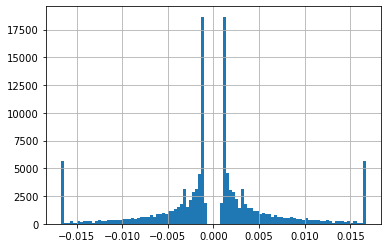

In [189]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)

In [190]:
from model.mma_features import RealEloWrapper

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
    # "ordinal_fighter_result",
    # "submission_fighter_result",
    # "tko_ko_fighter_result",
    # "decision_fighter_result",
    # "finish_fighter_result",
    "signed_inverse_fight_time",
    # "signed_inverse_sqrt_fight_time",
    # "signed_inverse_log_fight_time",
]
diff_elo_target_cols = [
]

binary_elo_target_cols = ["win_target", "win_target_finish"]

elo_alphas = {
    col: real_elo_alpha 
    for col in (real_elo_target_cols + diff_elo_target_cols)
}
# elo_alphas["ml_logit_mvmt"] = 0.225

real_ew = RealEloWrapper(elo_alphas=elo_alphas)
real_elo_feat_df = real_ew.fit_transform_all(df)
print(real_elo_feat_df.shape)
real_elo_feat_df.head()

elo_alphas = {
    col: bin_elo_alpha for col in binary_elo_target_cols
}
bin_ew = BinaryEloWrapper(elo_alphas=elo_alphas)
bin_elo_feat_df = bin_ew.fit_transform_all(df)
print(bin_elo_feat_df.shape)
bin_elo_feat_df.head()
# feat_ml_df["log_height_diff"] = np.log(feat_ml_df["imp_height"]) - np.log(feat_ml_df["imp_height_opp"])
# feat_ml_df["log_age_diff"] = np.log(feat_ml_df["age"]) - np.log(feat_ml_df["age_opp"])
# feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
# feat_ml_df["log_reach_diff"] = feat_ml_df["log_reach_diff"].fillna(0)

getting elo features for signed_inverse_fight_time


100%|██████████| 5194/5194 [00:06<00:00, 781.11it/s]


(133102, 9)
getting elo features for win_target


100%|██████████| 5194/5194 [00:06<00:00, 807.08it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 807.55it/s]


(133102, 15)


,FighterID_espn,OpponentID_espn,fight_id,win_target,pred_elo_win_target,fighter_elo_win_target,opponent_elo_win_target,updated_fighter_elo_win_target,updated_opponent_elo_win_target,win_target_finish,pred_elo_win_target_finish,fighter_elo_win_target_finish,opponent_elo_win_target_finish,updated_fighter_elo_win_target_finish,updated_opponent_elo_win_target_finish
0,2558095,2354059,1991-09-26_2354059_2558095,0.0,0.5,0.0,0.0,-0.1125,0.1125,0.0,0.5,0.0,0.0,-0.1125,0.1125
1,2354059,2558095,1991-09-26_2354059_2558095,1.0,0.5,0.0,0.0,0.1125,-0.1125,1.0,0.5,0.0,0.0,0.1125,-0.1125
2,2354119,2501396,1992-01-01_2354119_2501396,1.0,0.5,0.0,0.0,0.1125,-0.1125,1.0,0.5,0.0,0.0,0.1125,-0.1125
3,2501396,2354119,1992-01-01_2354119_2501396,0.0,0.5,0.0,0.0,-0.1125,0.1125,0.0,0.5,0.0,0.0,-0.1125,0.1125
4,2354132,3107994,1993-08-29_2354132_3107994,1.0,0.5,0.0,0.0,0.1125,-0.1125,1.0,0.5,0.0,0.0,0.1125,-0.1125


In [191]:
elo_feat_df = df.merge(
    pca_elo_feat_df, 
    how="left", 
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
).merge(
    real_elo_feat_df.drop(columns=real_elo_target_cols),
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
).merge(
    bin_elo_feat_df.drop(columns=binary_elo_target_cols),
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
)
print(elo_feat_df.shape)

(133102, 360)


In [192]:
elo_feat_df.notnull().sum()

fight_id                                  133102
Date                                      133102
FighterResult                             132984
Decision                                  132984
Rnd                                       133102
                                           ...  
pred_elo_win_target_finish                133102
fighter_elo_win_target_finish             133102
opponent_elo_win_target_finish            133102
updated_fighter_elo_win_target_finish     133102
updated_opponent_elo_win_target_finish    133102
Length: 360, dtype: int64

# Simpler features

In [193]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    assert (df["fight_id"].value_counts() == 2).all()
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    feat_df = df.sort_values("Date").copy()[[
        "fight_id", "FighterID_espn", "OpponentID_espn", "Date", "is_ufc"
    ]]
    # Rolling features over fighter_careers
    # because the data is doubled, we can simply group by the fighter id
    feat_df["dummy"] = 1
    # total fights
    feat_df["total_fights"] = feat_df.groupby("FighterID_espn")["dummy"].cumsum()
    feat_df["total_fights_opp"] = feat_df.groupby("OpponentID_espn")["dummy"].cumsum()
    # total ufc fights
    feat_df["total_ufc_fights"] = feat_df.groupby("FighterID_espn")["is_ufc"].cumsum()
    feat_df["total_ufc_fights_opp"] = feat_df.groupby("OpponentID_espn")["is_ufc"].cumsum()
    # time since last fight
    feat_df["t_since_last_fight"] = feat_df.groupby("FighterID_espn")["Date"].diff().dt.days
    feat_df["t_since_last_fight_opp"] = feat_df.groupby("OpponentID_espn")["Date"].diff().dt.days
    fill_val = 2*365 # arbitrarily say 2 years
    feat_df["t_since_last_fight"] = np.maximum(fill_val, feat_df["t_since_last_fight"].fillna(fill_val))   
    feat_df["t_since_last_fight_opp"] = np.maximum(fill_val, feat_df["t_since_last_fight_opp"].fillna(fill_val)) 
    # time since first fight
    feat_df["t_since_first_fight"] = (feat_df["Date"] - feat_df.groupby("FighterID_espn")["Date"].transform("min")).dt.days
    feat_df["t_since_first_fight_opp"] = (feat_df["Date"] - feat_df.groupby("OpponentID_espn")["Date"].transform("min")).dt.days
    # compute diffs
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    return feat_df

simple_feat_df = get_simple_features(elo_feat_df)
print(simple_feat_df.shape, elo_feat_df.shape)

(133102, 20) (133102, 360)


In [194]:
simple_feat_df.columns

Index(['fight_id', 'FighterID_espn', 'OpponentID_espn', 'Date', 'is_ufc',
       'dummy', 'total_fights', 'total_fights_opp', 'total_ufc_fights',
       'total_ufc_fights_opp', 't_since_last_fight', 't_since_last_fight_opp',
       't_since_first_fight', 't_since_first_fight_opp',
       't_since_last_fight_diff', 't_since_last_fight_log_diff',
       'total_fights_diff', 'total_fights_sqrt_diff', 'total_ufc_fights_diff',
       'total_ufc_fights_sqrt_diff'],
      dtype='object')

In [195]:
feat_ml_df = elo_feat_df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "Date"],
    suffixes=("_legacy", ""),
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)
feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
#     "ordinal_fighter_result",
#     "submission_fighter_result",
#     "tko_ko_fighter_result",
#     "decision_fighter_result",
    "signed_inverse_fight_time",
    # "finish_fighter_result",
    # *[col for col in stat_pca_df.columns 
    #   if col not in ["FighterID_espn", "OpponentID_espn", "Date"]],
]

feat_cols = [
    *[f"pred_elo_PC_{i}" for i in range(n_pca)],

    *["pred_elo_"+c for c in [*diff_elo_target_cols, 
                               *real_elo_target_cols, 
                               *binary_elo_target_cols]],
    
    # "t_since_last_fight_log_diff", 
#     "fights_per_day_diff",
#     "t_since_last_fight_diff",
#     "total_fights_sqrt_diff", 
#     "total_ufc_fights_diff",
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_prev_fight_diff",
    "log_t_since_first_fight_diff",
    "total_fights_diff",
#     "quad_log_t_since_first_fight_diff",
]

# new_feat_cols = [*feat_cols, "ml_logit"]
feat_cols

['pred_elo_PC_0',
 'pred_elo_PC_1',
 'pred_elo_PC_2',
 'pred_elo_PC_3',
 'pred_elo_PC_4',
 'pred_elo_PC_5',
 'pred_elo_PC_6',
 'pred_elo_PC_7',
 'pred_elo_PC_8',
 'pred_elo_PC_9',
 'pred_elo_PC_10',
 'pred_elo_PC_11',
 'pred_elo_PC_12',
 'pred_elo_PC_13',
 'pred_elo_signed_inverse_fight_time',
 'pred_elo_win_target',
 'pred_elo_win_target_finish',
 'age_diff',
 'log_reach_diff',
 'weight_diff',
 'height_diff',
 'log_t_since_prev_fight_diff',
 'log_t_since_first_fight_diff',
 'total_fights_diff']

In [196]:
feat_ml_df.columns[feat_ml_df.columns.str.contains("pred_")]

Index(['pred_elo_PC_0', 'pred_elo_PC_1', 'pred_elo_PC_2', 'pred_elo_PC_3',
       'pred_elo_PC_4', 'pred_elo_PC_5', 'pred_elo_PC_6', 'pred_elo_PC_7',
       'pred_elo_PC_8', 'pred_elo_PC_9', 'pred_elo_PC_10', 'pred_elo_PC_11',
       'pred_elo_PC_12', 'pred_elo_PC_13',
       'pred_elo_signed_inverse_fight_time', 'pred_elo_win_target',
       'pred_elo_win_target_finish'],
      dtype='object')

In [197]:
# checking to see how much data we have for each feature
feat_ml_df[feat_cols].notnull().sum()

pred_elo_PC_0                         133102
pred_elo_PC_1                         133102
pred_elo_PC_2                         133102
pred_elo_PC_3                         133102
pred_elo_PC_4                         133102
pred_elo_PC_5                         133102
pred_elo_PC_6                         133102
pred_elo_PC_7                         133102
pred_elo_PC_8                         133102
pred_elo_PC_9                         133102
pred_elo_PC_10                        133102
pred_elo_PC_11                        133102
pred_elo_PC_12                        133102
pred_elo_PC_13                        133102
pred_elo_signed_inverse_fight_time    133102
pred_elo_win_target                   133102
pred_elo_win_target_finish            133102
age_diff                              133102
log_reach_diff                        133102
weight_diff                           133102
height_diff                           133102
log_t_since_prev_fight_diff           133102
log_t_sinc

In [198]:
feat_ml_df = feat_ml_df.drop_duplicates(subset=["fight_id"])
print(feat_ml_df[feat_cols].notnull().sum())
feat_ml_df.shape

pred_elo_PC_0                         66551
pred_elo_PC_1                         66551
pred_elo_PC_2                         66551
pred_elo_PC_3                         66551
pred_elo_PC_4                         66551
pred_elo_PC_5                         66551
pred_elo_PC_6                         66551
pred_elo_PC_7                         66551
pred_elo_PC_8                         66551
pred_elo_PC_9                         66551
pred_elo_PC_10                        66551
pred_elo_PC_11                        66551
pred_elo_PC_12                        66551
pred_elo_PC_13                        66551
pred_elo_signed_inverse_fight_time    66551
pred_elo_win_target                   66551
pred_elo_win_target_finish            66551
age_diff                              66551
log_reach_diff                        66551
weight_diff                           66551
height_diff                           66551
log_t_since_prev_fight_diff           66551
log_t_since_first_fight_diff    

(66551, 384)

# Model evaluation - opening line

Note that this isn't realistic. Don't get your hopes up

In [199]:
p_fighter_implied_col = "p_fighter_open_implied"

In [200]:
from model.mma_log_reg_stan import SimpleSymmetricModel

mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

In [201]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col=p_fighter_implied_col)
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -19407.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5882.87    0.00754549       1.91117           1           1       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22      -5882.87   0.000398029     0.0889822           1           1       24   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-16
Initial log joint probability = -18313.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5890.81    0.00316872      0.967578           1           1       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -5890.81   0.000202928     0.0665365           1           1       24   
Opti

In [202]:
mod_pred = preds_df["y_pred"].round()
ml_pred = preds_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == preds_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == preds_df["win_target"]).mean())

Model accuracy:      0.6836532097948379
Moneyline accuracy:  0.6671078755790867


In [203]:
from sklearn.metrics import log_loss

xce = log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])
xce_ml = log_loss(y_true=preds_df["win_target"], y_pred=preds_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Moneyline log loss: {xce_ml}")

model log loss    : 0.5863996340772879
Moneyline log loss: 0.6093059101142347


In [204]:
list(zip(mod.feat_cols, mod.fit['beta']))

[('pred_elo_PC_0', 0.12450440556756572),
 ('pred_elo_PC_1', -0.002821310401073378),
 ('pred_elo_PC_2', 0.008058694728148814),
 ('pred_elo_PC_3', 0.016002551471038528),
 ('pred_elo_PC_4', 0.028055441771392055),
 ('pred_elo_PC_5', -0.01896971655752299),
 ('pred_elo_PC_6', 0.014311270745261336),
 ('pred_elo_PC_7', -0.02503059408866972),
 ('pred_elo_PC_8', 0.002172635590656807),
 ('pred_elo_PC_9', 0.01706635243419307),
 ('pred_elo_PC_10', 0.019637498268429896),
 ('pred_elo_PC_11', -0.011845469525640386),
 ('pred_elo_PC_12', -0.017419943161882775),
 ('pred_elo_PC_13', 0.047408855883789895),
 ('pred_elo_signed_inverse_fight_time', -0.07071769167196695),
 ('pred_elo_win_target', 0.413489145572239),
 ('pred_elo_win_target_finish', -0.4065394565780645),
 ('age_diff', 0.25082992900563594),
 ('log_reach_diff', 0.04293612594498792),
 ('weight_diff', 0.01304635672972162),
 ('height_diff', 0.023562739649030336),
 ('log_t_since_prev_fight_diff', -0.16472521254888464),
 ('log_t_since_first_fight_diff'

In [205]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week

In [206]:
fighter_ml_col = "FighterOpen"
opponent_ml_col = "OpponentOpen"

overall winnings


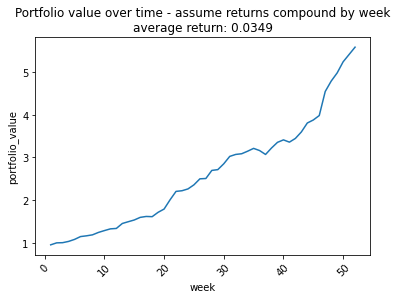

ufc winnings


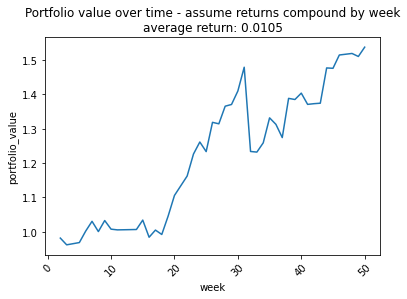

non-ufc winnings


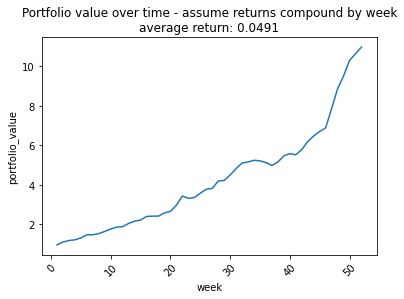

In [207]:
from model_selection.metrics import MultiKellyPM

kwargs = {
    "max_bankroll_fraction": 0.05,
    "groupby_col": "week",
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}

print("overall winnings")
pm = MultiKellyPM(preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Model evaluation - BetMGM, DraftKings, BetFair

I think something's fishy here, this can't be right

In [208]:
close_df = base_db_interface.read("clean_bfo_close_data")
# double the data
fighter_cols = [c for c in close_df.columns if c.endswith("_fighter")]
opponent_cols = [c[:-len("_fighter")] + "_opponent" for c in fighter_cols]
for col in fighter_cols + opponent_cols:
    close_df[col] = close_df[col].str.replace("▲", "")\
        .str.replace("▼", "")\
        .astype(float)
    
close_df_complement = close_df.rename(columns={
    "FighterID": "OpponentID",
    "OpponentID": "FighterID",
    **{f: o for f, o in zip(fighter_cols, opponent_cols)},
    **{o: f for f, o in zip(fighter_cols, opponent_cols)},
})
close_df = pd.concat([close_df, close_df_complement], axis=0)\
    .drop_duplicates(subset=["FighterID", "OpponentID", "EventHref"])\
    .dropna(subset=["FighterID", "OpponentID", "EventHref"])\
    .rename(columns={"FighterID": "FighterID_bfo", "OpponentID": "OpponentID_bfo"})\
    .drop(columns=["FighterName", "OpponentName"])\
    .reset_index(drop=True)

print(close_df.shape)
close_df.isnull().mean()

(16250, 26)


match_id               0.000000
EventHref              0.000000
DraftKings_fighter     0.765046
BetMGM_fighter         0.792862
Caesars_fighter        0.786954
BetRivers_fighter      0.863877
FanDuel_fighter        0.764554
PointsBet_fighter      0.904000
Unibet_fighter         0.813908
BetWay_fighter         0.658954
5D_fighter             0.086154
Ref_fighter            0.018338
FighterID_bfo          0.000000
Bet365_fighter         0.902031
DraftKings_opponent    0.765046
BetMGM_opponent        0.792862
Caesars_opponent       0.786954
BetRivers_opponent     0.863877
FanDuel_opponent       0.764554
PointsBet_opponent     0.904000
Unibet_opponent        0.813908
BetWay_opponent        0.658954
5D_opponent            0.086154
Ref_opponent           0.018338
OpponentID_bfo         0.000000
Bet365_opponent        0.902031
dtype: float64

In [209]:
preds_df["FighterID_bfo"]

122872            Calvin-Kattar-717
122873                Wu-Yanan-8993
122874             Justin-Tafa-9315
122875           Jacob-Kilburn-8472
122876           Ramazan-Emeev-7452
                    ...            
132966    Christian-Rodriquez-15110
132967      Gerald-Meerschaert-3628
132971        Cynthia-Calvillo-6940
132980       Magomed-Umalatov-11254
132981            David-Zawada-5347
Name: FighterID_bfo, Length: 3022, dtype: object

In [210]:
aug_preds_df = preds_df.merge(
    close_df,
    how="left",
    on=["FighterID_bfo", "OpponentID_bfo", "EventHref"],
)
aug_preds_df.isnull().mean()

fight_id_legacy    0.000000
Date               0.000000
FighterResult      0.000000
Decision           0.000000
Rnd                0.000000
                     ...   
Unibet_opponent    0.573461
BetWay_opponent    0.269689
5D_opponent        0.425215
Ref_opponent       0.271013
Bet365_opponent    0.795169
Length: 410, dtype: float64

In [211]:
close_df[["DraftKings_fighter", "BetMGM_fighter"]]

,DraftKings_fighter,BetMGM_fighter
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
16245,-365.0,-450.0
16246,NaN,-450.0
16247,-435.0,-450.0
16248,575.0,600.0


In [212]:
preds_df[fighter_ml_col]

122872    115.0
122873   -240.0
122874   -105.0
122875    225.0
122876   -210.0
          ...  
132966    210.0
132967    250.0
132971    275.0
132980   -900.0
132981    125.0
Name: FighterOpen, Length: 3022, dtype: object

overall winnings


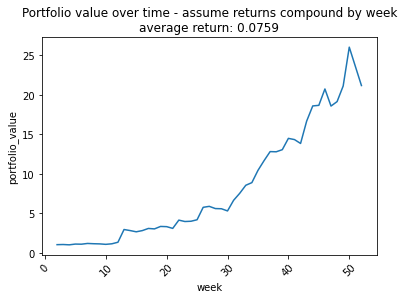

ufc winnings


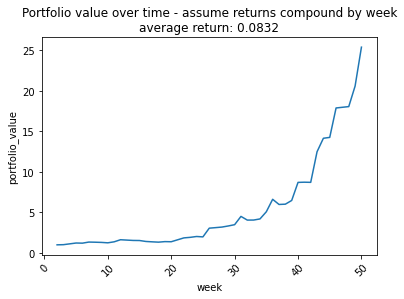

non-ufc winnings


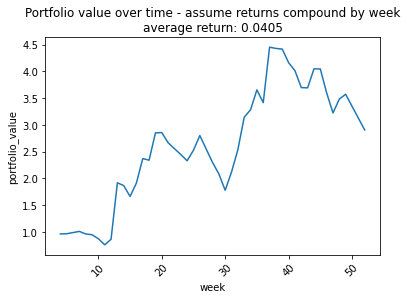

In [213]:
market = "DraftKings"
# market = "BetMGM"

kwargs = {
    "max_bankroll_fraction": 1,
    "groupby_col": "week",
    "fighter_ml_col": f"{market}_fighter",
    "opponent_ml_col": f"{market}_opponent",
}

temp_preds_df = aug_preds_df.dropna(subset=[
    f"{market}_fighter", f"{market}_opponent"
])
temp_preds_df

print("overall winnings")
pm = MultiKellyPM(temp_preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Predictions for upcoming fights

In [214]:
# feat_ml_df.query("Date == '2023-04-15'")[["FighterName", "OpponentName"]]
feat_ml_df.query("is_upcoming == 1")[["FighterID_espn", "OpponentID_espn", *feat_cols]]

,FighterID_espn,OpponentID_espn,pred_elo_PC_0,pred_elo_PC_1,pred_elo_PC_2,pred_elo_PC_3,pred_elo_PC_4,pred_elo_PC_5,pred_elo_PC_6,pred_elo_PC_7,...,pred_elo_signed_inverse_fight_time,pred_elo_win_target,pred_elo_win_target_finish,age_diff,log_reach_diff,weight_diff,height_diff,log_t_since_prev_fight_diff,log_t_since_first_fight_diff,total_fights_diff
132984,4863327,3949555,-0.195705,-0.249167,-0.068994,0.682357,0.265850,0.332739,-0.606089,0.157302,...,-0.000824,0.572789,0.529700,7.317808,0.081126,0.0,4.0,-0.528675,-0.510659,-7
132985,4397782,4040197,0.112259,0.714654,0.967333,-1.279557,0.390686,-0.224637,0.238147,0.725284,...,-0.002596,0.507695,0.560020,1.295890,0.036368,0.0,0.0,0.084218,-0.146069,-5
132986,4232775,3994033,0.202585,0.976380,0.029361,-1.416281,-0.196303,-0.420252,0.437974,-0.305062,...,-0.000838,0.543284,0.660596,-2.369863,0.006645,0.0,1.0,0.354646,-0.046496,3
132987,4076472,4063667,0.210980,0.391183,-0.089732,-0.591662,-0.648010,0.036722,0.744049,-0.196450,...,-0.000849,0.543324,0.527520,-0.950685,0.013793,0.0,3.0,0.507671,0.142094,-3
132988,3045734,3961293,-0.381281,-0.505066,0.555358,0.363368,0.224523,0.700904,0.680059,-0.225259,...,0.000486,0.421996,0.584334,-4.624658,-0.030305,0.0,-3.0,0.619535,0.358149,4
132989,2335674,4690549,0.285680,-0.398737,0.437694,-1.458451,-0.138322,0.162732,-0.757358,-0.317639,...,0.000959,0.506069,0.417221,-12.665753,0.000000,0.0,0.0,0.110348,0.809855,39
132991,2594871,4227265,-0.194510,0.650643,-0.265063,-0.548014,0.247813,0.141773,0.096254,-1.325625,...,0.000098,0.500631,0.468554,-1.021918,0.061036,0.0,5.0,-0.375433,-0.061522,13
132993,3900088,2526299,0.345742,0.411075,-0.050783,0.761484,-0.134104,-1.021289,-1.008232,0.382047,...,0.000154,0.514171,0.576980,2.882192,-0.068993,0.0,-1.0,-1.164626,-0.320020,-12
132996,3902098,2614933,-0.981286,-0.950759,-0.842446,0.633129,-0.954096,-0.628756,0.892606,-0.476728,...,-0.001054,0.480028,0.430665,2.136986,0.014389,0.0,-3.0,-0.533062,-0.133283,-10
132997,4394200,4963343,0.321315,0.165845,-0.302548,0.084098,0.106047,0.583619,-0.376468,0.366369,...,-0.001841,0.547239,0.502525,-6.315068,0.038915,0.0,4.0,0.018780,0.409856,3


In [236]:
# from wrangle.clean_bfo_data import parse_american_odds

train_df = feat_ml_df.query("is_upcoming == 0")\
    .dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col
    ], how="any")
test_df = feat_ml_df.query("Date == '2023-04-15'").copy()
train_df.shape, test_df.shape

((12915, 384), (13, 384))

In [237]:
mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

y_pred = mod.fit_predict(train_df, test_df, feat_cols)
y_pred

Initial log joint probability = -27421.8


array([0.71080858, 0.4167712 , 0.59135897, 0.52973717, 0.18859853,
       0.28878326, 0.66659051, 0.63481703, 0.44319354, 0.5662856 ,
       0.40209936, 0.39251686, 0.77878135])

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -7651.29      0.003545       1.65107           1           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -7651.28   0.000445495      0.173913      0.8069      0.8069       25   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [243]:
preds_df = test_df.assign(y_pred = y_pred)
preds_df[["FighterName", "OpponentName", 
          "FighterOpen", "OpponentOpen", 
          p_fighter_implied_col, "y_pred"]]

,FighterName,OpponentName,FighterOpen,OpponentOpen,p_fighter_open_implied,y_pred
132984,daniel zellhuber,lando vannata,-175,+150,0.614035,0.710809
132985,joselyne edwards,lucie pudilova,+150,-175,0.385965,0.416771
132986,tanner boser,ion curelaba,-160,+140,0.596273,0.591359
132987,bill algeo,tj brown,-139,+119,0.560185,0.529737
132988,pedro munhoz,chris gutierrez,+200,-235,0.322115,0.188599
132989,clay guida,rafa garcia,+140,-160,0.403727,0.288783
132991,dustin jacoby,azamat murzakanov,-200,+170,0.642857,0.666591
132993,billy quarantillo,edson barboza,-155,+135,0.588212,0.634817
132996,arnold allen,max holloway,+125,-145,0.428884,0.443194
132997,bruna brasil,denise gomes,-160,+140,0.596273,0.566286


In [259]:
ml_df = pd.DataFrame([['daniel zellhuber', 'lando vannata', "-130", "+110"],
['joselyne edwards', 'lucie pudilova', "+115", "-135"],
['tanner boser', 'ion curelaba', "+110", "-130"],
['bill algeo', 'tj brown', "-190", "+160"],
['pedro munhoz', 'chris gutierrez', "+170", "-200"],
['clay guida', 'rafa garcia', "+215", "-255"],
['dustin jacoby', 'azamat murzakanov', "-150", "+130"],
['billy quarantillo', 'edson barboza', "-170", "+145"],
['arnold allen', 'max holloway', "+140", "-165"],
['bruna brasil', 'denise gomes', "-150", "+130"],
['gillian robertson', 'piera rodriguez', "-125", "+105"],
['brandon royval', 'matheus nicolau', "+170", "-200"],
['zak cummings', 'ed herman', "-225", "+190"]], 
columns=["FighterName", "OpponentName", "DraftKings_fighter", "DraftKings_opponent"])
ml_df

,FighterName,OpponentName,DraftKings_fighter,DraftKings_opponent
0,daniel zellhuber,lando vannata,-130,+110
1,joselyne edwards,lucie pudilova,+115,-135
2,tanner boser,ion curelaba,+110,-130
3,bill algeo,tj brown,-190,+160
4,pedro munhoz,chris gutierrez,+170,-200
5,clay guida,rafa garcia,+215,-255
6,dustin jacoby,azamat murzakanov,-150,+130
7,billy quarantillo,edson barboza,-170,+145
8,arnold allen,max holloway,+140,-165
9,bruna brasil,denise gomes,-150,+130


In [263]:
aug_preds_df = preds_df.merge(
    ml_df,
    on=["FighterName", "OpponentName"],
    how="left"
)
aug_preds_df["DraftKings_fighter"] = aug_preds_df["DraftKings_fighter"].astype(int)
aug_preds_df["DraftKings_opponent"] = aug_preds_df["DraftKings_opponent"].astype(int)
aug_preds_df

,fight_id_legacy,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,age_diff,log_reach_diff,weight_diff,height_diff,t_since_first_fight_diff,log_t_since_first_fight_diff,log_t_since_prev_fight_diff,y_pred,DraftKings_fighter,DraftKings_opponent
0,2023-04-15_3949555_4863327,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,3949555,4863327,NaN,...,7.317808,0.081126,0.0,4.0,-1596,-0.510659,-0.528675,0.710809,-130,110
1,2023-04-15_4040197_4397782,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,4040197,4397782,NaN,...,1.295890,0.036368,0.0,0.0,-455,-0.146069,0.084218,0.416771,115,-135
2,2023-04-15_3994033_4232775,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,3994033,4232775,NaN,...,-2.369863,0.006645,0.0,1.0,-183,-0.046496,0.354646,0.591359,110,-130
3,2023-04-15_4063667_4076472,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,4063667,4076472,NaN,...,-0.950685,0.013793,0.0,3.0,526,0.142094,0.507671,0.529737,-190,160
4,2023-04-15_3045734_3961293,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,3961293,3045734,NaN,...,-4.624658,-0.030305,0.0,-3.0,1547,0.358149,0.619535,0.188599,170,-200
5,2023-04-15_2335674_4690549,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,4690549,2335674,NaN,...,-12.665753,0.000000,0.0,0.0,3870,0.809855,0.110348,0.288783,215,-255
6,2023-04-15_2594871_4227265,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,4227265,2594871,NaN,...,-1.021918,0.061036,0.0,5.0,-287,-0.061522,-0.375433,0.666591,-150,130
7,2023-04-15_2526299_3900088,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,2526299,3900088,NaN,...,2.882192,-0.068993,0.0,-1.0,-1400,-0.320020,-1.164626,0.634817,-170,145
8,2023-04-15_2614933_3902098,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,2614933,3902098,NaN,...,2.136986,0.014389,0.0,-3.0,-574,-0.133283,-0.533062,0.443194,140,-165
9,2023-04-15_4394200_4963343,2023-04-15,None,None,-,-,UFC Fight Night: Holloway vs. Allen,4963343,4394200,NaN,...,-6.315068,0.038915,0.0,4.0,1036,0.409856,0.018780,0.566286,-150,130


In [269]:
from model_selection.metrics import MultiKellyPM

pm = MultiKellyPM(aug_preds_df, max_bankroll_fraction=0.05,
                  fighter_ml_col="DraftKings_fighter",
                    opponent_ml_col="DraftKings_opponent",
                  parse_ml=True)
pw = pm.get_portfolio_weights().merge(preds_df[["FighterID_espn", "OpponentID_espn", "FighterName", "OpponentName"]])
pw[["FighterName", "fighter_bet", "OpponentName", "opponent_bet"]]

,FighterName,fighter_bet,OpponentName,opponent_bet
0,daniel zellhuber,0.030442,lando vannata,0.000000
1,joselyne edwards,0.000000,lucie pudilova,0.001872
2,tanner boser,0.019988,ion curelaba,0.000000
3,bill algeo,0.000000,tj brown,0.012652
4,pedro munhoz,0.000000,chris gutierrez,0.039473
5,clay guida,0.000000,rafa garcia,0.000000
6,dustin jacoby,0.015134,azamat murzakanov,0.000000
7,billy quarantillo,0.001273,edson barboza,0.000000
8,arnold allen,0.004134,max holloway,0.000000
9,bruna brasil,0.000000,denise gomes,0.000000


In [271]:
a = pw[["FighterName", "fighter_bet", "DraftKings_fighter", "OpponentName", "opponent_bet", "DraftKings_opponent"]].copy()
a["fighter_bet"] = 100*a["fighter_bet"]
a["opponent_bet"] = 100*a["opponent_bet"]
a

KeyError: "['DraftKings_fighter', 'DraftKings_opponent'] not in index"